In [1]:
using Pkg
if isfile("../Project.toml") && isfile("../Manifest.toml")
    Pkg.activate("..");
end

function printer(x::Any, verbose="")
    if verbose != ""
        println(verbose)
    end
    show(stdout, "text/plain", x)
    println("")
end
using CSV, DataFrames, Plots, StatsPlots, Statistics, StatsBase
gr()

 Activating environment at `~/Programming/julia/notebook/JuliaProbo/Project.toml`


Plots.GRBackend()

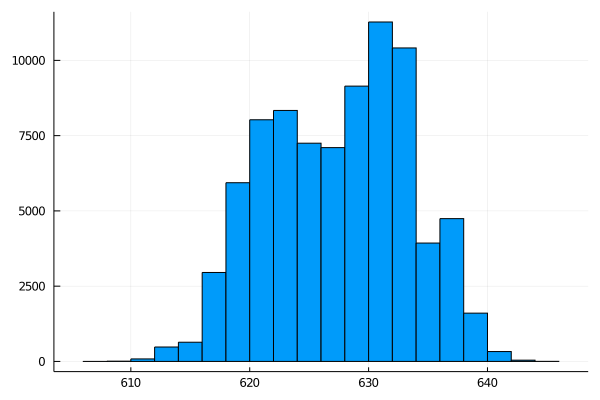

In [2]:
data = DataFrame(CSV.File("../sensor_data/sensor_data_600.txt"; header=["date", "time", "ir", "lidar"], types=[Float64, Float64, Float64, Float64]))
histogram(data.lidar, bins=:sturges, label=nothing)

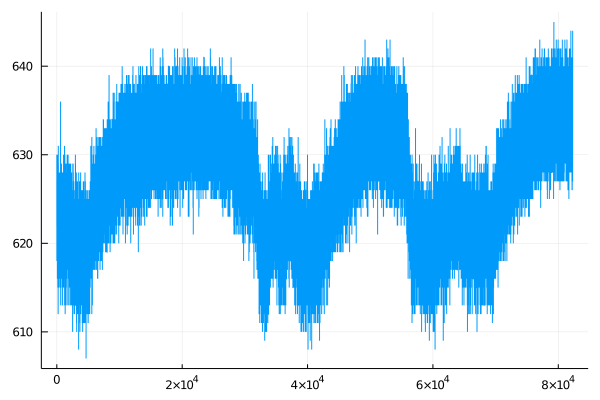

In [3]:
plot(data.lidar, label=nothing)

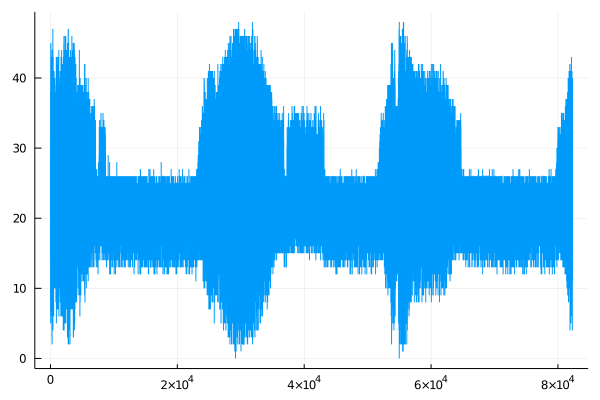

In [4]:
plot(data.ir, label=nothing)

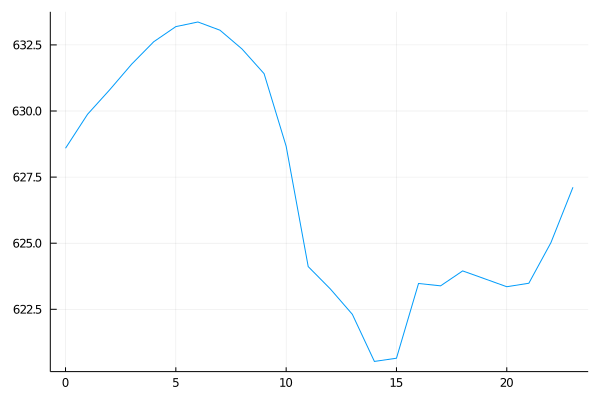

In [5]:
data.hour = [floor(e / 10000) * 1.0 for e in data.time]
data_group_hours = groupby(data, :hour)

lidar_hour_means = (Array{Float64, 1})[]
for data_group_hour in data_group_hours
    hour = data_group_hour.hour[1]
    group_mean = sum(data_group_hour.lidar) / size(data_group_hour.lidar)[1]
    push!(lidar_hour_means, [hour, group_mean])
end
len = size(lidar_hour_means)[1]
lidar_hour_means = sort(lidar_hour_means)
plot([lidar_hour_means[i][1] for i in 1:len], [lidar_hour_means[i][2] for i in 1:len], legend=nothing)

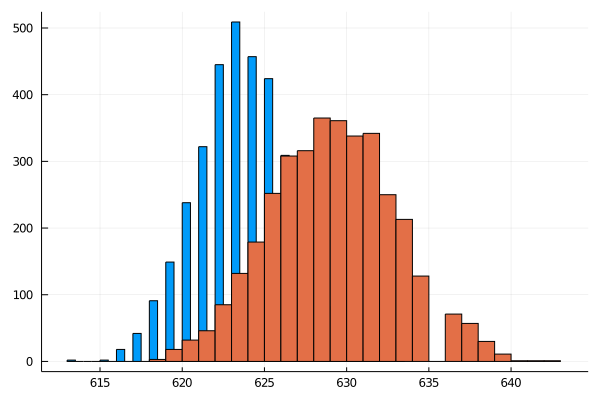

In [6]:
histogram(data_group_hours[6].lidar, legend=nothing)
histogram!(data_group_hours[14].lidar, legend=nothing)

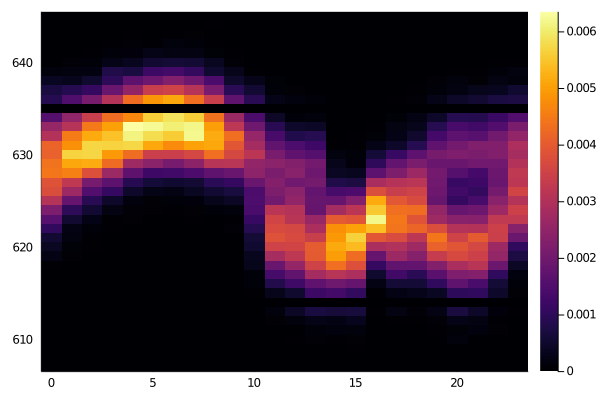

In [7]:
each_hours = Dict()
for i in 1:24
    push!(each_hours, data_group_hours[i].hour[1] => countmap(data_group_hours[i].lidar))
end
lidar_min = minimum(data_group_hours[1].lidar)
lidar_max = maximum(data_group_hours[1].lidar)
for i in 2:24
    lidar_min = min(lidar_min, minimum(data_group_hours[i].lidar))
    lidar_max = max(lidar_max, maximum(data_group_hours[i].lidar))
end
freqs = zeros(convert(Int64, floor(lidar_max - lidar_min)), 24)
lidar_vals = collect(range(lidar_min, lidar_max, step=1.0))
freqs = zeros(size(lidar_vals)[1], 24)
for each_hour in each_hours
    hour = each_hour[1] + 1
    lidar_cnt = each_hour[2]
    for (val, cnt) in lidar_cnt
        ind = convert(Int64, val - lidar_min) + 1
        freqs[ind, convert(Int64, hour)] += cnt
    end
end
freqs /= size(data.lidar)[1]
heatmap(0:23, lidar_vals, freqs)

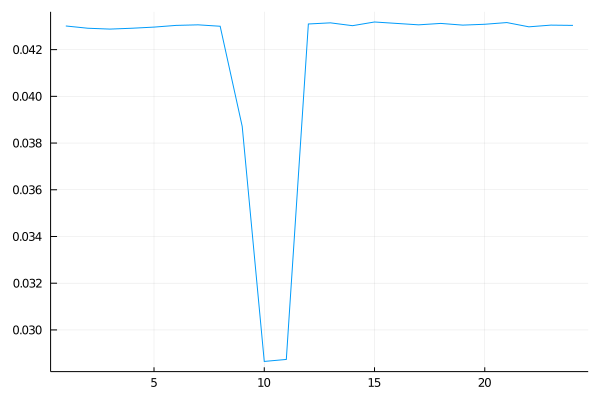

In [8]:
p_t = sum(freqs, dims=1)
plot(1:24, p_t[1, :], legend=nothing)

In [9]:
sum(p_t)

0.9999999999999999

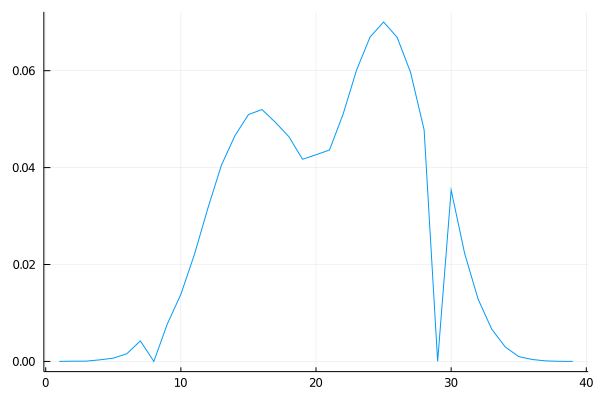

In [10]:
p_z = sum(freqs, dims=2)
plot(p_z, legend=nothing)

In [11]:
cond_z_t = copy(freqs)
p_t = sum(cond_z_t, dims=1)
for i in 1:size(cond_z_t)[1]
   cond_z_t[i, :] = cond_z_t[i, : ] ./ p_t[1, :]
end

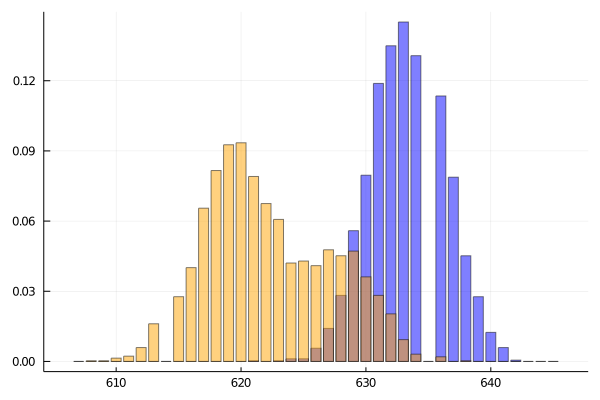

In [12]:
plot(lidar_vals, cond_z_t[:, 6], seriestype=:bar, alpha=0.5, color="blue", legend=nothing)
plot!(lidar_vals, cond_z_t[:, 14], seriestype=:bar, alpha=0.5, color="orange", legend=nothing)

In [13]:
cond_t_z = copy(freqs)
cond_t_z = transpose(cond_t_z)
p_z = sum(cond_t_z, dims=1)
for i in 1:size(cond_t_z)[1]
    cond_t_z[i, :] = cond_t_z[i, :] ./ p_z[1, :]
end
println("P(z=630) = ", p_z[1, convert(Int64, 630-lidar_min+1)])
println("P(t=13) = ", p_t[1, 14])
println("P(t=13 | z=630) = ", cond_t_z[13, convert(Int64, 630-lidar_min+1),])
println("Bayes P(z=630 | t=13) = ", cond_t_z[13, convert(Int64, 630-lidar_min+1)]*p_z[1, convert(Int64, 630-lidar_min+1)]/p_t[1, 13])
println("answer P(z=630 | t=13) = ", cond_z_t[convert(Int64, 630-lidar_min+1), 13])

P(z=630) = 0.06694936878045224
P(t=13) = 0.043024993620976656
P(t=13 | z=630) = 0.025952813067150637
Bayes P(z=630 | t=13) = 0.04027034638130104
answer P(z=630 | t=13) = 0.04027034638130104


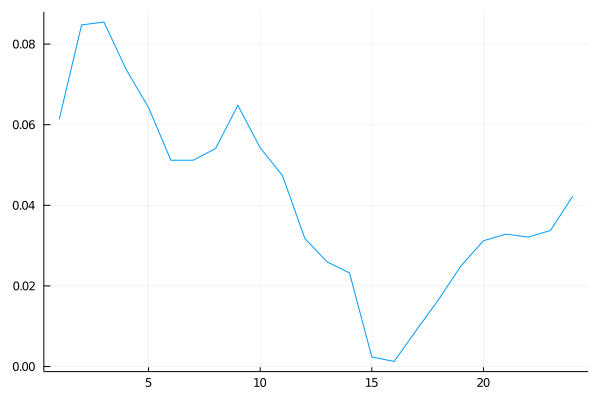

In [14]:
function bayes_estimation(sensor_value::Float64, current_estimation::AbstractArray{Float64, 1})
    len = size(current_estimation)[1]
    new_estimation = zeros(len)
    for i in 1:len
        new_estimation[i] = cond_z_t[convert(Int64, sensor_value-lidar_min+1), i] * current_estimation[i]
    end
    
    return new_estimation / sum(new_estimation)
end

estimation = bayes_estimation(630.0, p_t[1, :])
plot(estimation, legend=nothing)

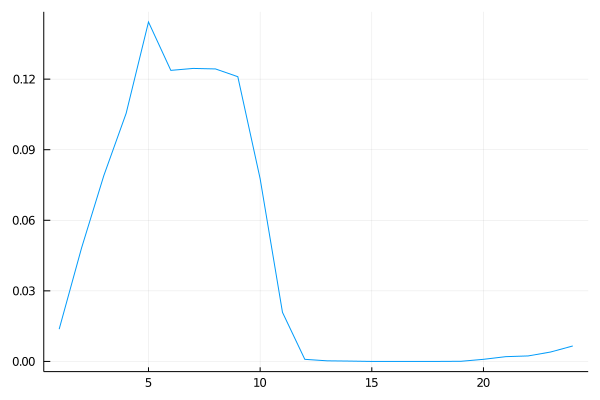

In [15]:
values_5 = [630.0 632.0 636]
estimation = copy(p_t[1, :])
for v in values_5
    estimation = bayes_estimation(v, estimation)
end

plot(estimation, legend=nothing)

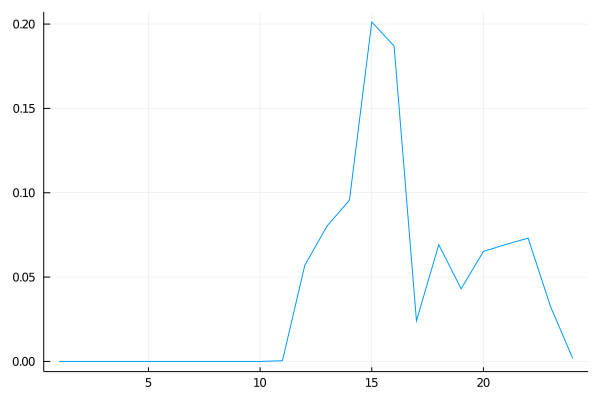

In [16]:
values_11 = [617.0 624.0 619.0]

estimation = copy(p[1, :])
for v in values_11
    estimation = bayes_estimation(v, estimation)
end

plot(estimation, legend=nothing)